# Nested hierarchy example

Insert path to synthesis module:

In [1]:
import config

In [2]:
from pllaux import EHXPLLConfig

INT_FEEDBACK = False

PLL = EHXPLLConfig(100.0)

PLL.setClk(25.0) # Set primary clock in MHz
PLL.setClk(33.0, 1, 1) # Set secondary clock in MHz

PLL.params.internal_feedback = INT_FEEDBACK # Use feedback

PLL_CONFIG = PLL.configure()

print("Effective: %.2f MHz" % PLL.f_out)
print("VCO: %.2f MHz" % PLL.f_vco)
print()

Calculate PLL values for 25.00 MHz
mul: 1, div: 4
too low VCO 25.0
Effective: 25.00 MHz
VCO: 400.00 MHz



In [3]:
from myhdl import *
from synthesis.yosys.ecp5.components import EHXPLLL

@block
def pll(clki, clk0, clk1, lock):
    intlock, lock0 = [ Signal(bool()) for i in range(2) ]
    clkop, clkos, clkos2, clkos3 = [ Signal(bool()) for i in range(4) ]
    refclk, clkintfb = [ Signal(bool()) for i in range(2) ]
    fb, intlock = [ Signal(bool()) for i in range(2) ]

    e = EHXPLLL(clki, fb, False, False, False, False, \
        False, False, \
        False, False, \
        False, False, False, False, \
        clkop, clkos, clkos2, clkos3, lock0, intlock, \
        refclk, clkintfb, \
        **PLL_CONFIG)

    @always_comb
    def assign():
        clk0.next = clkop
        clk1.next = clkos

        if INT_FEEDBACK:
            fb.next = clkintfb
        else:
            fb.next = clkop

        lock.next = lock0
    
    return instances()

We create a blinker submodule, driving two LEDs:

In [4]:
@block
def blinker(clk, rst, led0, led1, POS = 0):
    "Blinker toggling leds by slicing (aka power by two division)"
    counter_a, counter_b = [ Signal(intbv(0)[30:]) for i in range(2) ]
    inst_c0 = up_counter(clk, 1, rst, counter_a)
    inst_c1 = up_counter(clk, 1, rst, counter_b)
    
    @always_comb
    def assign():
        if __debug__:
            if POS > 5:
                raise ValueError("Divider POS value too big")
        led0.next = counter_a[22 + POS]
        led1.next = counter_a[24 + POS]

    return instances()
    

### UART loopback

In [5]:
@block
def uart_translator(clk, txd, rxd, DIV = 200):
    "Simple UART translation, direct hard loopthrough"
    @always_comb
    def loopback():
        txd.next = rxd
        
    return instances()

## Top level entity

Then we create the top level module. It's input/output ports are the true hardware ports as described in the preference file (LPF).

In [6]:
from myhdl import *

from frequently_used import up_counter, lfsr8

@block
def ecp5test(clk_in, reset_n, uart_rxd, uart_txd, led, CLK_FREQ):
    "Top level entity with UART hard loopback"

    # Array of internal outputs:
    o = [ Signal(bool()) for i in range(6) ]

    reset = ResetSignal(0, 1, False)

    clk = [ Signal(bool()) for i in range(3) ]
    lock = Signal(bool())

    # Divider position values, the higher, the slower
    DIV_POS = [2, 1, 3]
    
    # Instance three blinkers
    bl = [ blinker(clk[i], reset, o[i * 2], o[i * 2 + 1], DIV_POS[i]) for i in range(3) ]
    
    l_out = Signal(intbv()[8:])

    # Instance the above PLL unit:
    inst_pll = pll(clk_in, clk[0], clk[1], lock)

    inst_uart_loopback = uart_translator(clk[0], uart_txd, uart_rxd)       

    @always_comb
    def assign():
        l_out.next = concat(o[0], o[1], o[2], o[3], lock, False, o[4], o[5] )
        reset.next = not reset_n
        
    @always(clk[0])
    def clk_wire():
        "Use same clock for [0] and [2]"
        clk[2].next = clk[0]
        
    @always_comb
    def assign_out():
        "Wire LED and UART hard loopback"
        led.next = not l_out
    
    return instances()

### Synthesis

In [7]:
from myhdl.conversion import yshelper

clk_in = Signal(bool())
uart_rxd, uart_txd = [ Signal(bool()) for i in range(2) ]
led = Signal(modbv()[8:])
reset_n = ResetSignal(1, 0, False)

blinky = ecp5test(clk_in, reset_n, uart_rxd, uart_txd, led, 10000000)

design = yshelper.Design("blinky")
blinky.convert("yosys_module", design)

design.finalize("top")

VCO div: 1 mul: 4
VCO div: 1 mul: 4
Tolerating undefined bit width of VCO_0_0_edge for blackbox simulation
Tolerating undefined bit width of VCO_0_0_lastedge for blackbox simulation
	Infer blackbox: 'VCO_0_0'
Adding module with name: VCO_1_c0_1_1_c1_c4
Adding module with name: up_counter_1_c1_1_30
CONVERT_RTL tree >>>>>> 'ECP5TEST_BLINKER_0_UP_COUNTER_0_WORKER' 
TRUNC: /home/pyosys/src/myhdl/myhdl-local/example/ipynb/work/myhdl-synthesis/examples/frequently_used.py:17 Implicit carry truncate: counter_a[30:], src[31:]
	Infer blackbox: 'EHXPLLL_0_0'
Adding module with name: EHXPLLL_1_1_c0_c0_c0_c0_c0_c0_c0_c0_c0_c0_c0_c0_1_1_1_1_1_1_1_1
config param PLLRST_ENA = DISABLED
config param INTFB_WAKE = DISABLED
config param STDBY_ENABLE = DISABLED
config param DPHASE_SOURCE = DISABLED
config param OUTDIVIDER_MUXA = DIVA
config param OUTDIVIDER_MUXB = DIVB
config param OUTDIVIDER_MUXC = DIVC
config param OUTDIVIDER_MUXD = DIVD
config param CLKI_DIV = 4
config param CLKOP_ENABLE = ENABLED
config

## Hierarchy checks

We run an I/O sanity check and display the RTL of the toplevel entity:

In [8]:
design.run("check", silent=False)

Note: Capturing currently broken


Generating RTL image...
Display...


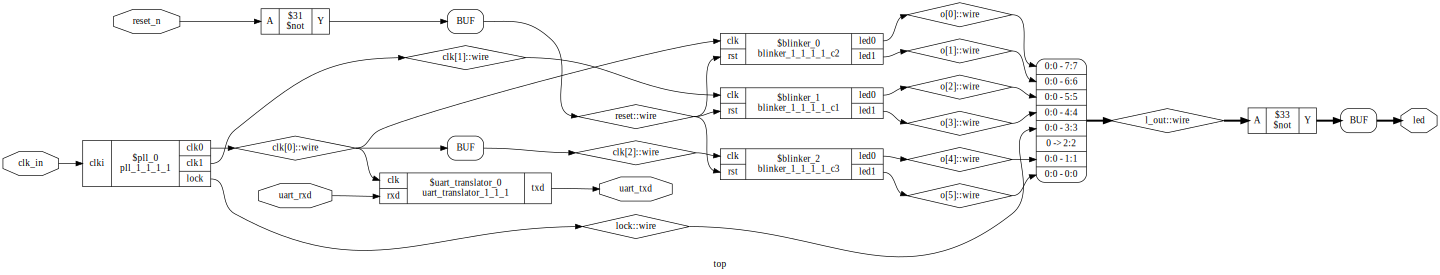

In [9]:
from ys_aux import to_svg
# design.write_verilog("ecp5test")
display(to_svg(design, "top", 200))

**Note**: For each unique value in `DIV_POS`, a specific blinker module is created. It is recognized by the identifier.

### Exercise

1. Change the `DIV_POS` values, observe changes in the module identifier (and blink frequency)
+  Enter same values for all three and observe synthesis creating only one blinker entity

## FPGA mapping and download

In [10]:
from ecp5aux import synthesize

synthesize(design)

json_filename = "ecp5test.json"

design.run("write_json %s" % json_filename)

### Download

Proceed to [Place'n'Route and download](ecp5_versa_download.ipynb) to download this example into the target.